In [1]:
import glob 
import numpy as np
import networkx as nx
from collections import defaultdict
from cdlib import algorithms
import matplotlib.pyplot as plt
from cdlib.evaluation import modularity_overlap as modularity

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score
from collections import Counter

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'bayanpy', 'wurlitzer', 'graph_tool', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


In [2]:
list_of_graphs = glob.glob("/Users/arjuns/Downloads/notebooks_v2/v2/graphs/*/*.graphml")

true_categories = {
    list_of_graphs[i].split("/")[-1].split(".")[0] : list_of_graphs[i].split("/")[-2] for i in range(len(list_of_graphs))
}

In [14]:
graphs = {}
files = glob.glob("../l2_graphs/*.graphml")

In [15]:
for file in files:
    print(f"Loading {file}")
    graph = nx.read_graphml(file)
    name = file.split("/")[-1].split(".")[0] + "." + file.split("/")[-1].split(".")[1]
    # print(name)
    graphs[float(name)] = graph

Loading ../l2_graphs/0.004.graphml
Loading ../l2_graphs/0.00476995213776347.graphml
Loading ../l2_graphs/0.007177177177177177.graphml
Loading ../l2_graphs/0.005335335335335335.graphml
Loading ../l2_graphs/0.006286286286286286.graphml
Loading ../l2_graphs/0.00965965965965966.graphml
Loading ../l2_graphs/0.0098998998998999.graphml
Loading ../l2_graphs/0.008008008008008008.graphml
Loading ../l2_graphs/0.005205205205205205.graphml
Loading ../l2_graphs/0.008948948948948949.graphml
Loading ../l2_graphs/0.005735735735735736.graphml
Loading ../l2_graphs/0.005045045045045045.graphml
Loading ../l2_graphs/0.008308308308308308.graphml
Loading ../l2_graphs/0.007787787787787787.graphml
Loading ../l2_graphs/0.004824824824824825.graphml
Loading ../l2_graphs/0.009219219219219218.graphml
Loading ../l2_graphs/0.0036136136136136134.graphml
Loading ../l2_graphs/0.007587587587587588.graphml
Loading ../l2_graphs/0.006666666666666666.graphml
Loading ../l2_graphs/0.004194194194194194.graphml
Loading ../l2_grap

In [16]:
graphs.keys()

dict_keys([0.004, 0.00476995213776347, 0.007177177177177177, 0.005335335335335335, 0.006286286286286286, 0.00965965965965966, 0.0098998998998999, 0.008008008008008008, 0.005205205205205205, 0.008948948948948949, 0.005735735735735736, 0.005045045045045045, 0.008308308308308308, 0.007787787787787787, 0.004824824824824825, 0.009219219219219218, 0.0036136136136136134, 0.007587587587587588, 0.006666666666666666, 0.004194194194194194, 0.005995995995995996, 0.004024024024024024, 0.008558558558558558, 0.005495495495495496, 0.008128128128128128, 0.007417417417417417, 0.0035135135135135136, 0.004454454454454454, 0.009429429429429429])

In [5]:
def get_homogeneity_scores(partition_dict):
    # Tracking node assignments across communities to identify overlaps
    node_assignments = defaultdict(list)
    for community_id, subreddits in partition_dict.items():
        for subreddit in subreddits:
            node = subreddit.split("/")[-1]  # Extract the node identifier
            node_assignments[node].append(community_id)
    
    # Compute the most common category for each community
    most_common_category_dict = {}
    for community_id, subreddits in partition_dict.items():
        categories = [true_categories[subreddit.split("/")[-1].split(".")[0]] for subreddit in subreddits if subreddit.split("/")[-1].split(".")[0] in true_categories]
        category_counts = Counter(categories)
        if category_counts:
            most_common_category, _ = category_counts.most_common(1)[0]
            most_common_category_dict[community_id] = most_common_category
        else:
            most_common_category_dict[community_id] = None  # No valid category found

    # Calculate the homogeneity for each community using weighted contributions
    homogeneity_scores = {}
    for community_id, subreddits in partition_dict.items():
        categories = []
        weights = []
        for subreddit in subreddits:
            node = subreddit.split("/")[-1]
            if node in true_categories:
                category = true_categories[node]
                categories.append(category)
                # Weight inversely proportional to correct community assignments
                if category == most_common_category_dict[community_id]:
                    correct_assignments = [cid for cid in node_assignments[node] if true_categories[node] == most_common_category_dict[cid]]
                    weights.append(1 / len(correct_assignments) if correct_assignments else 1)
                else:
                    weights.append(1)
        
        category_counts = Counter(categories)
        if category_counts:
            most_common_category, _ = category_counts.most_common(1)[0]
            weighted_counts = sum(w for cat, w in zip(categories, weights) if cat == most_common_category)
            homogeneity = weighted_counts / sum(weights) if sum(weights) > 0 else 0
        else:
            homogeneity = 0
        
        homogeneity_scores[community_id] = homogeneity
    
     # Calculate mean and median homogeneity
    mean_homogeneity = np.mean(list(homogeneity_scores.values())) if homogeneity_scores else 0
    median_homogeneity = np.median(list(homogeneity_scores.values())) if homogeneity_scores else 0
    
    return mean_homogeneity, median_homogeneity


In [6]:
def calculate_community_metrics(partition_dict):
    true_labels = []
    predicted_labels = []
    y_true = []
    y_pred = []
    
    for comm_id, subreddits in partition_dict.items():
        comm_categories = []
        
        for subreddit in subreddits:
            sub_name = subreddit.split("/")[-1].split(".")[0]
            if sub_name in true_categories:
                true_cat = true_categories[sub_name]
                true_labels.append(true_cat)
                predicted_labels.append(comm_id)
                comm_categories.append(true_cat)
        
        if comm_categories:
            majority_category = Counter(comm_categories).most_common(1)[0][0]
            y_pred.extend([majority_category]*len(comm_categories))
            y_true.extend(comm_categories)
    
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    ari = adjusted_rand_score(true_labels, predicted_labels)
    f1 = f1_score(y_true, y_pred, average='macro') if y_true else 0.0
    
    return nmi, ari, f1

In [7]:
def remove_single_node_communities(partition):
    temp = {k: v for k, v in partition.items() if len(v) > 1}
    return temp, partition

In [8]:
def validate_partition(G, partition):
    """ Ensure every node is covered exactly once in the partition. """
    all_nodes = set(G.nodes())
    covered_nodes = set()
    for community in partition:
        if not community:  # Skip empty communities if any
            continue
        community_set = set(community)
        if not covered_nodes.isdisjoint(community_set):
            raise ValueError("Overlap detected in communities")
        covered_nodes.update(community_set)

    if covered_nodes != all_nodes:
        raise ValueError("Partition does not cover all nodes")

In [64]:
# print node attributes
def get_node_attr(G, attr):
    node_attr = {}
    for node in G.nodes():
        node_attr[node] = G.nodes[node][attr]

    return node_attr

In [ ]:
import logging
from collections import defaultdict

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def angel(G, threshold=0.9):
    communities = algorithms.angel(G, threshold=threshold)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def demon(G, epsilon=0.6):
    communities = algorithms.demon(G, epsilon=epsilon)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def percomvc(G):
    G_copy = G.copy()
    communities = algorithms.percomvc(G_copy)
    id2node = get_node_attr(G, "subreddit")
    return {i: [id2node[node] for node in comm] for i, comm in enumerate(communities.communities)}, communities

def core_expansion(G):
    communities = algorithms.core_expansion(G)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def slpa(G, r=0.1):
    communities = algorithms.slpa(G, r=r)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def multicom(G):
    communities = algorithms.multicom(G, seed_node=0)
    return {i: [com.split("/")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

algorithms_list = [angel, demon, core_expansion, slpa, multicom, umstmo]

metrics = defaultdict(lambda: defaultdict(dict))

for threshold, graph in graphs.items():
    if threshold == 0.004:
        continue
    for algorithm in algorithms_list:
        logger.info(f"Running {algorithm.__name__} for threshold {threshold}")
        partition, comm = algorithm(graph)
        partition, original = remove_single_node_communities(partition)

        if len(partition) <= 1:
            logger.warning(f"Skipping {algorithm.__name__} for threshold {threshold}: partition has 1 or fewer communities")
            continue

        # Calculate existing metrics
        mean_homogeneity, median_homogeneity = get_homogeneity_scores(partition)
        nmi, ari, f1 = calculate_community_metrics(partition)
        mod = modularity(graph, comm)

        metrics[algorithm.__name__][threshold]["modularity"] = mod
        metrics[algorithm.__name__][threshold]["mean_homogeneity"] = mean_homogeneity
        metrics[algorithm.__name__][threshold]["median_homogeneity"] = median_homogeneity
        metrics[algorithm.__name__][threshold]["nmi"] = nmi
        metrics[algorithm.__name__][threshold]["ari"] = ari
        metrics[algorithm.__name__][threshold]["f1"] = f1

        logger.info(f"Metrics calculated for {algorithm.__name__} at threshold {threshold}")
        logger.info(f"Modularity: {modularity}, Mean Homogeneity: {mean_homogeneity}, Median Homogeneity: {median_homogeneity}")
        logger.info(f"NMI: {nmi}, ARI: {ari}, F1: {f1}")

logger.info("Processing completed for all algorithms and thresholds.")


In [21]:
import pickle
def dump_pickle(data, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)   
    
dump_pickle(dict(metrics), "./metrics/ocd_metrics.pkl")

In [23]:
metrics

defaultdict(<function __main__.<lambda>()>,
            {'angel': defaultdict(dict,
                         {0.00476995213776347: {'modularity': FitnessResult(min=None, max=None, score=-0.03675714405753485, std=None),
                           'mean_homogeneity': 0.5642621990791333,
                           'median_homogeneity': 0.6470588235294118,
                           'nmi': 0.22796725031604187,
                           'ari': 0.03151963763109392,
                           'f1': 0.2066221257485267},
                          0.007177177177177177: {'modularity': FitnessResult(min=None, max=None, score=-0.03553554779614636, std=None),
                           'mean_homogeneity': 0.5958415273474503,
                           'median_homogeneity': 0.5864077669902912,
                           'nmi': 0.4099756588648405,
                           'ari': 0.0691690348042995,
                           'f1': 0.5383323623596472},
                          0.005335335335335335:

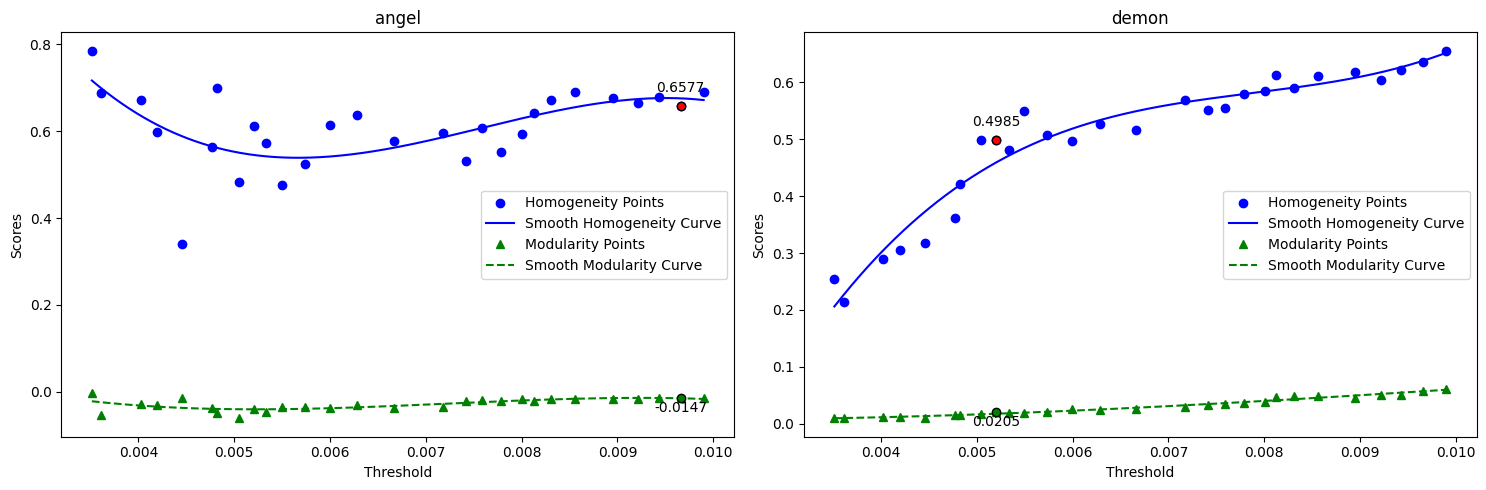

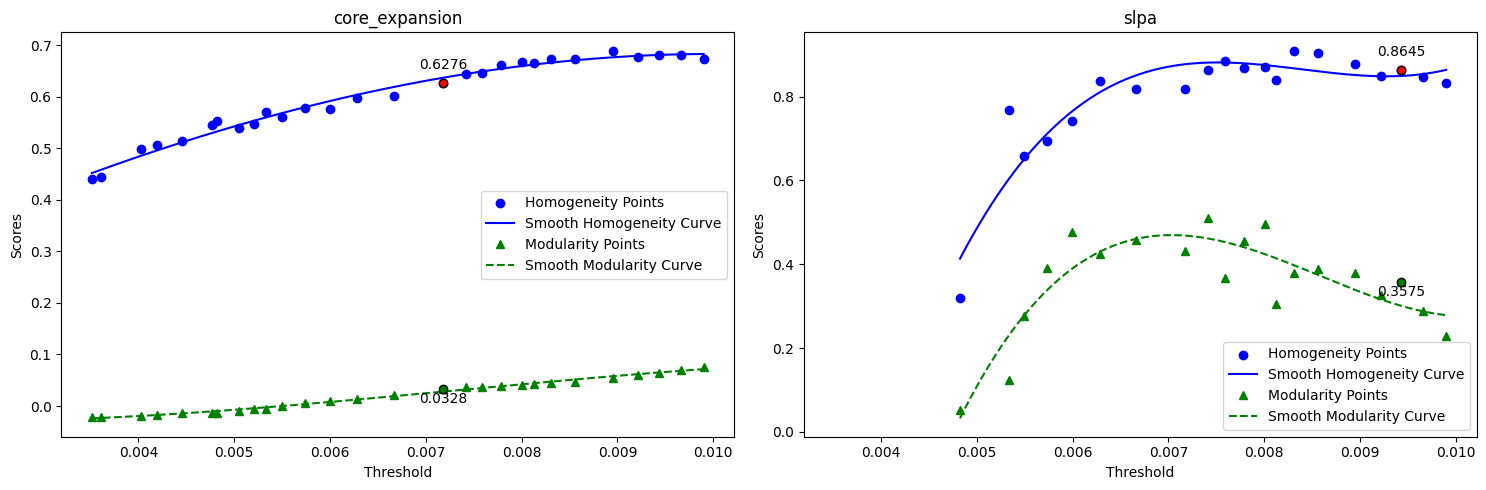

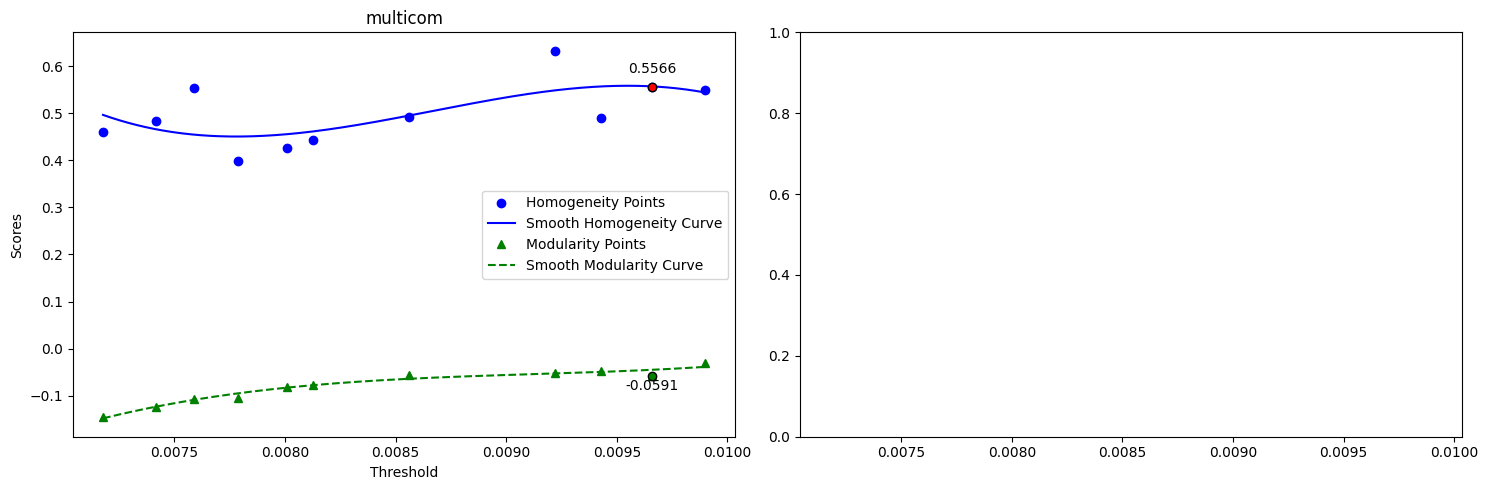

In [31]:
def plot(data, algorithms, target_threshold=[]):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=False)
    axes = axes.flatten()  # Flatten the array of axes for easier iteration

    algorithms = [algo.__name__ if callable(algo) else algo for algo in algorithms]

    for idx, algo in enumerate(algorithms):
        thresholds = np.array(list(data[algo].keys()))
        homogeneities = np.array([data[algo][threshold]['mean_homogeneity'] for threshold in thresholds])
        modularities = np.array([data[algo][threshold]['modularity'].score for threshold in thresholds])

        # Sorting data for plotting
        sorted_indices = np.argsort(thresholds)
        thresholds = thresholds[sorted_indices]
        homogeneities = homogeneities[sorted_indices]
        modularities = modularities[sorted_indices]

        # Fit a smooth line for homogeneity
        z_homogeneity = np.polyfit(thresholds, homogeneities, 3)  # Cubic polynomial
        p_homogeneity = np.poly1d(z_homogeneity)
        
        # Generate a smooth range of thresholds for smoother curve
        smooth_thresholds = np.linspace(thresholds.min(), thresholds.max(), 500)
        smooth_homogeneities = p_homogeneity(smooth_thresholds)

        # Fit a smooth line for modularity
        z_modularity = np.polyfit(thresholds, modularities, 3)  # Cubic polynomial
        p_modularity = np.poly1d(z_modularity)
        smooth_modularities = p_modularity(smooth_thresholds)

        # Plotting each algorithm's homogeneity data
        axes[idx].scatter(thresholds, homogeneities, color='blue', label='Homogeneity Points')
        axes[idx].plot(smooth_thresholds, smooth_homogeneities, 'b-', label='Smooth Homogeneity Curve')

        # Plotting each algorithm's modularity data
        axes[idx].plot(thresholds, modularities, 'g^', label='Modularity Points')
        axes[idx].plot(smooth_thresholds, smooth_modularities, 'g--', label='Smooth Modularity Curve')

        if target_threshold[idx] is not None and target_threshold[idx] in thresholds:
            tgt = target_threshold[idx]
            target_index = np.where(thresholds == tgt)[0][0]
            target_homogeneity = homogeneities[target_index]
            target_modularity = modularities[target_index]
            
            axes[idx].scatter(tgt, target_homogeneity, color='red', edgecolor='black', zorder=5)
            axes[idx].annotate(f'{target_homogeneity:.4f}', (tgt, target_homogeneity),
                               textcoords="offset points", xytext=(0,10), ha='center')

            # Optionally mark modularity at the target threshold
            axes[idx].scatter(tgt, target_modularity, color='green', edgecolor='black', zorder=5)
            axes[idx].annotate(f'{target_modularity:.4f}', (tgt, target_modularity),
                               textcoords="offset points", xytext=(0,-10), ha='center')

        axes[idx].set_title(algo)
        axes[idx].set_xlabel('Threshold')
        axes[idx].set_ylabel('Scores')
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

# Example usage with target_threshold=0.0059
plot(metrics, algorithms_list[:2], target_threshold=[0.00965965965965966, 0.005205205205205205])
plot(metrics, algorithms_list[2:4], target_threshold=[0.007177177177177177, 0.009429429429429429])
plot(metrics, algorithms_list[4:6], target_threshold=[0.00965965965965966, 0.00965965965965966])

In [33]:
import pickle
def dump_pickle(data, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)   

In [34]:
ocd_metrics = load_pickle("./metrics/ocd_metrics.pkl")

In [36]:
def find_best_metrics(metrics):
    best_thresholds = {}

    # Identify best threshold for each algorithm
    for algorithm in metrics:
        best_threshold = None
        best_score = float('-inf')  # Initialize with the lowest possible score
        
        for threshold in metrics[algorithm]:
            # Calculate the overall score (sum of selected metrics)
            score = (
                metrics[algorithm][threshold]["modularity"].score
                + metrics[algorithm][threshold]["mean_homogeneity"]
                + metrics[algorithm][threshold]["nmi"]
                + metrics[algorithm][threshold]["ari"]
                + metrics[algorithm][threshold]["f1"]
            )

            # Update best threshold if the score improves
            if score > best_score:
                best_score = score
                best_threshold = threshold

        best_thresholds[algorithm] = best_threshold

        # Print all metrics for the best threshold
        best_metrics = metrics[algorithm][best_threshold]
        print(f"Best threshold for {algorithm}: {best_threshold}")
        print(f"Modularity: {best_metrics['modularity']}")
        print(f"Mean Homogeneity: {best_metrics['mean_homogeneity']}")
        print(f"NMI: {best_metrics['nmi']}")
        print(f"ARI: {best_metrics['ari']}")
        print(f"F1: {best_metrics['f1']}")
        print("="*50)

# find_best_metrics(metrics)
find_best_metrics(ocd_metrics)

Best threshold for angel: 0.0098998998998999
Modularity: FitnessResult(min=None, max=None, score=-0.014484569537678888, std=None)
Mean Homogeneity: 0.6906520475239208
NMI: 0.4191558918714102
ARI: 0.029251647644230914
F1: 0.5621236670311965
Best threshold for demon: 0.0098998998998999
Modularity: FitnessResult(min=None, max=None, score=0.0610839733080439, std=None)
Mean Homogeneity: 0.6554906955375766
NMI: 0.39943085345508716
ARI: 0.05655327248421828
F1: 0.6139825098632781
Best threshold for core_expansion: 0.008948948948948949
Modularity: FitnessResult(min=None, max=None, score=0.0535083352806612, std=None)
Mean Homogeneity: 0.6893816029839164
NMI: 0.3984265109261742
ARI: 0.03387721649833247
F1: 0.6844332533344295
Best threshold for slpa: 0.007417417417417417
Modularity: FitnessResult(min=None, max=None, score=0.5111726171887351, std=None)
Mean Homogeneity: 0.8643790849673202
NMI: 0.6446026952897262
ARI: 0.4497246774758076
F1: 0.5075280112044818
Best threshold for multicom: 0.009659659

In [38]:
algos = ["angel", "demon", "core_expansion", "slpa"]

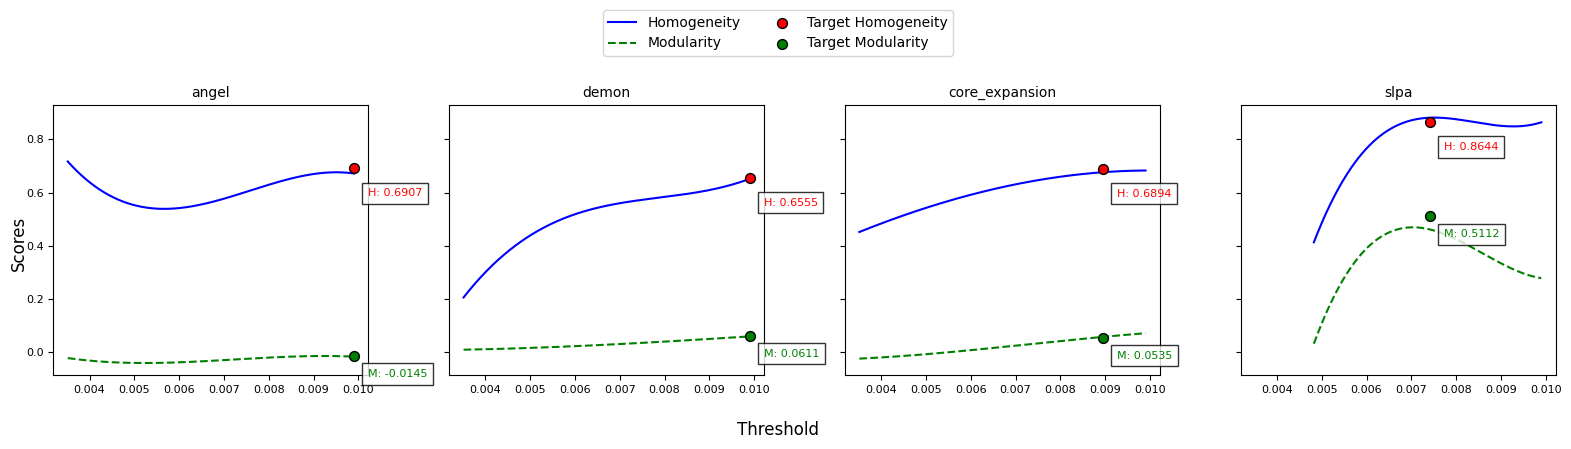

In [55]:
def plot_compact(data, algorithms, target_threshold=[]):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, algo in enumerate(algorithms):
        if idx >= len(axes):  
            break

        thresholds = np.array(list(data[algo].keys()))
        homogeneities = np.array([data[algo][threshold]['mean_homogeneity'] for threshold in thresholds])
        modularities = np.array([data[algo][threshold]['modularity'].score for threshold in thresholds])

        f1 = np.array([data[algo][threshold]['f1'] for threshold in thresholds])
        nmi = np.array([data[algo][threshold]['nmi'] for threshold in thresholds])
        ari = np.array([data[algo][threshold]['ari'] for threshold in thresholds])

        sorted_indices = np.argsort(thresholds)
        thresholds, homogeneities, modularities = thresholds[sorted_indices], homogeneities[sorted_indices], modularities[sorted_indices]

        smooth_thresholds = np.linspace(thresholds.min(), thresholds.max(), 500)
        p_homogeneity = np.poly1d(np.polyfit(thresholds, homogeneities, 3))
        p_modularity = np.poly1d(np.polyfit(thresholds, modularities, 3))

        axes[idx].plot(smooth_thresholds, p_homogeneity(smooth_thresholds), 'b-', label='Homogeneity')
        axes[idx].plot(smooth_thresholds, p_modularity(smooth_thresholds), 'g--', label='Modularity')
        
        # print(idx)
        if idx < len(target_threshold) and target_threshold[idx] in thresholds:
            tgt = target_threshold[idx]
            target_index = np.where(thresholds == tgt)[0][0]
            target_homogeneity = homogeneities[target_index]
            target_modularity = modularities[target_index]

            axes[idx].scatter(tgt, target_homogeneity, color='red', edgecolor='black', zorder=5, label="Target Homogeneity", s=50)
            axes[idx].scatter(tgt, target_modularity, color='green', edgecolor='black', zorder=5, label="Target Modularity", s=50)

            # Dynamic Annotation Placement
            y_min, y_max = axes[idx].get_ylim()
            title_height = y_max - (y_max - y_min) * 0.15  # 15% below the top

            homogeneity_offset = 10 if target_homogeneity < title_height else -20
            modularity_offset = -15 if target_modularity < title_height else -30

            axes[idx].annotate(f'H: {target_homogeneity:.4f}', (tgt, target_homogeneity),
                               textcoords="offset points", xytext=(10, homogeneity_offset), fontsize=8,
                               ha='left', color='red', bbox=dict(facecolor='white', alpha=0.8))
            
            axes[idx].annotate(f'M: {target_modularity:.4f}', (tgt, target_modularity),
                               textcoords="offset points", xytext=(10, modularity_offset), fontsize=8,
                               ha='left', color='green', bbox=dict(facecolor='white', alpha=0.8))
            
        axes[idx].set_title(algo, fontsize=10)
        axes[idx].tick_params(axis='both', which='major', labelsize=8)

    fig.supxlabel("Threshold", fontsize=12)
    fig.supylabel("Scores", fontsize=12)

    handles, labels = axes[0].get_legend_handles_labels()
    
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


plot_compact(ocd_metrics, algos, 
             target_threshold=[0.0098998998998999, 0.0098998998998999, 0.008948948948948949, 0.007417417417417417])
